# Explain an Intermediate Layer of VGG16 on ImageNet (PyTorch)

Explaining a prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). This notebook gives a simple example of how to use GradientExplainer to do explain a model output with respect to the 7th layer of the pretrained VGG16 network.

Note that by default 200 samples are taken to compute the expectation. To run faster you can lower the number of samples per explanation.

In [1]:
import json

import numpy as np
import torch
from torchvision import models

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from keras.preprocessing import image

import shap

2024-02-12 16:26:47.803084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 16:26:48.038920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 16:26:48.038955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 16:26:48.040046: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 16:26:48.160274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

#### Loading the model : VGG19

In [3]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
model.eval()

X, y = shap.datasets.imagenet50()

We load the image saved in the **data** folder

In [4]:
# load the model
img_path = "../data/Trousse.jpg"
img = image.load_img(img_path, target_size=(224, 224))
im = image.img_to_array(img)
im = np.expand_dims(im, axis=0)
print('Input image shape:', im.shape)

X[0] = im
X /= 255
to_explain = X[[0]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

Input image shape: (1, 224, 224, 3)


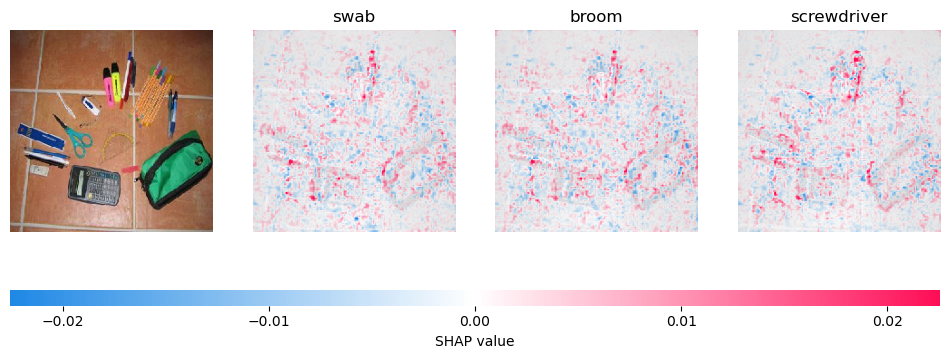

In [5]:
e = shap.GradientExplainer((model, model.features[7]), normalize(X))
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=3, nsamples=5
)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(
    X[1:3], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

In [ ]:
# Partitions 

# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    #preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X[0:2], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

In [ ]:
shap.image_plot(shap_values_partitions)

## Explain with local smoothing

Gradient explainer uses expected gradients, which merges ideas from integrated gradients, SHAP, and SmoothGrad into a single expection equation. To use smoothing like SmoothGrad just set the local_smoothing parameter to something non-zero. This will add normally distributed noise with that standard deviation to the input during the expectation calculation. It can create smoother feature attributions that better capture correlated regions of the image.

In [ ]:
# note that because the inputs are scaled to be between 0 and 1, the local smoothing also has to be
# scaled compared to the Keras model
explainer = shap.GradientExplainer(
    (model, model.features[7]), normalize(X), local_smoothing=0.5
)
shap_values, indexes = explainer.shap_values(
    normalize(to_explain), ranked_outputs=2, nsamples=200
)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)